In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

import model
from dataset import PathDataset, RandomCutDataset ## cropped dataset
from metrics import jiffs, kagglejiffs
from utils import gen_jilist

In [2]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))

hidden_channels_list = [16, 32, 64, 128, 256]
scale_list           = [(2, 1, 1)]
nblocks              = 2
s_nblocks            = 2
activation           = nn.ReLU()
dropout              = 0.5
partial              = (64, 192) ########################
JNet = model.JNet(hidden_channels_list  = hidden_channels_list ,
                  nblocks               = nblocks              ,
                  s_nblocks             = s_nblocks            ,
                  activation            = activation           ,
                  dropout               = dropout              ,
                  scale_list            = scale_list           ,
                  mu_z                  = 0.2                  ,
                  sig_z                 = 0.2                  ,
                  bet_xy                = 6.                   ,
                  bet_z                 = 35.                  ,
                  superres              = False                ,
                  )
JNet = JNet.to(device = device)
scale = 1
val_dataset   = RandomCutDataset(folderpath  =  'randomdata'     ,  ###
                                 imagename   =  '_x1'            ,
                                 labelname   =  '_label'         ,
                                 size        =  (768, 768, 768)  ,
                                 cropsize    =  (128, 128, 128)  ,
                                 I           =  200              ,
                                 low         =   16              ,
                                 high        =   20              ,
                                 scale       =    1              ,
                                 train       = False             ,
                                )

In [3]:
model_name = 'JNet_77_x1'
jis77 = gen_jilist(JNet, model_name, val_dataset, device, partial=None)

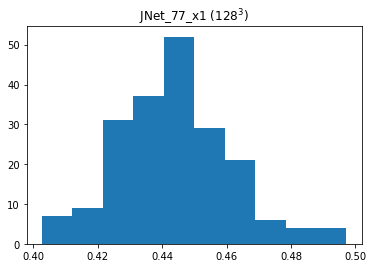

0.44388542 0.017603246


In [4]:
plt.hist(jis77)
plt.title(r'{} ($128^3$)'.format(model_name))
plt.show()
print(np.mean(jis77), np.std(jis77))

In [5]:
model_name = 'JNet_81_x1_256'
JNet.load_state_dict(torch.load(f'model/{model_name}.pt'))
val_dataset256 = RandomCutDataset(folderpath  =  'randomdata'     ,  ###
                                  imagename   =  '_x1'            ,
                                  labelname   =  '_label'         ,
                                  size        =  (768, 768, 768)  ,
                                  cropsize    =  (256,  64,  64)  ,
                                  I           =  200              ,
                                  low         =   16              ,
                                  high        =   20              ,
                                  scale       =    1              ,
                                  train       = False             ,
                                 )

In [6]:
jis81 = gen_jilist(JNet, model_name, val_dataset256, device, partial=None)

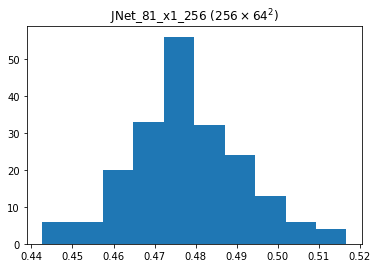

0.4776585 0.013837018


In [7]:
plt.hist(jis81)
plt.title(r'{} ($256 \times 64^2$)'.format(model_name))
plt.show()
print(np.mean(jis81), np.std(jis81))

In [13]:
def gen_jilist(model, model_name, val_dataset, device, partial=None):
    model.load_state_dict(torch.load(f'model/{model_name}.pt'))
    model.eval()
    jis = []
    for i in range(len(val_dataset)):
        image, label = val_dataset[i]
        if partial is not None:
            label = label[:, partial[0]:partial[1], :, :].detach()
        image   = image.to(device=device).unsqueeze(0)
        pred, _ = model(image)
        pred    = pred.to(device='cpu').squeeze(0)
        if partial is not None:
            pred = pred[:, partial[0]:partial[1], :, :].detach()
        jis.append(jiffs(pred, label))
    return jis

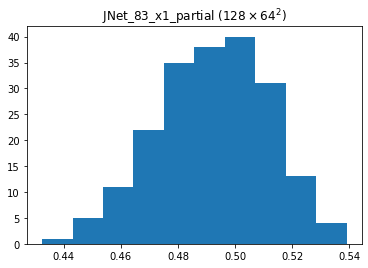

0.4917022 0.019046634


In [31]:
model_name = 'JNet_83_x1_partial'
JNet.load_state_dict(torch.load(f'model/{model_name}.pt'))
jis83 = gen_jilist(JNet, model_name, val_dataset256, device, partial=(64, 192))
plt.hist(jis83)
plt.title(r'{} ($128 \times 64^2$)'.format(model_name))
plt.show()
print(np.mean(jis83), np.std(jis83))

In [14]:
model_name = 'JNet_86_x1_partial'
JNet.load_state_dict(torch.load(f'model/{model_name}.pt'))
jis86 = gen_jilist(JNet, model_name, val_dataset, device, partial=(32, 96))

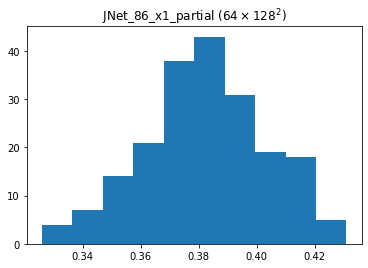

0.3820448 0.02094473


In [15]:
plt.hist(jis86)
plt.title(r'{} ($64 \times 128^2$)'.format(model_name))
plt.show()
print(np.mean(jis86), np.std(jis86))

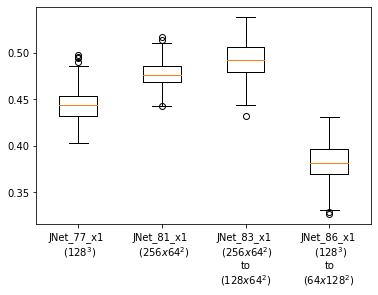

In [93]:
plt.boxplot((jis77, jis81, jis83, jis86))
plt.xticks([1,2,3,4],  ['JNet_77_x1 \n ($128^3$)'     ,
                        'JNet_81_x1 \n ($256 x 64^2$)',
                        'JNet_83_x1 \n ($256 x 64^2$)\nto\n($128 x 64^2$)',
                        'JNet_86_x1 \n ($128^3$)\nto\n($64 x 128^2$)',])
plt.show()

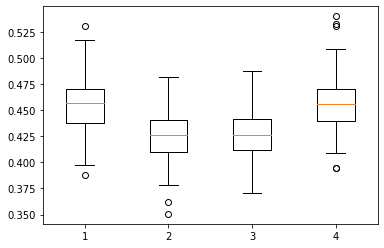

In [61]:
model_name = 'JNet_77_x1'
JNet.load_state_dict(torch.load(f'model/{model_name}.pt'))

val_dataset224 = RandomCutDataset(folderpath  =  'randomdata'     ,  ###
                                  imagename   =  '_x1'            ,
                                  labelname   =  '_label'         ,
                                  size        =  (768, 768, 768)  ,
                                  cropsize    =  (224, 128, 128)  ,
                                  I           =  200              ,
                                  low         =   16              ,
                                  high        =   20              ,
                                  scale       =    1              ,
                                  train       = False             ,
                                 )

jiss = [[],[],[],[]]

for i in range(len(val_dataset224)):
    image, label = val_dataset224[i]
    label = label.chunk(chunks=7, dim=1)[3]
    for j in range(4):
        simage  = image[:, j*32:j*32+128, :, :].to(device=device).unsqueeze(0)
        pred, _ = JNet(simage)
        pred    = pred.to(device='cpu').squeeze(0)
        pred = pred[:, (3-j)*32:(4-j)*32, :, :].detach()
        jiss[3-j].append(jiffs(pred, label))
plt.boxplot((jiss))
plt.show()

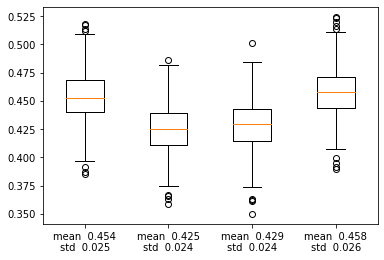

In [92]:
model_name = 'JNet_77_x1'
JNet.load_state_dict(torch.load(f'model/{model_name}.pt'))

val_dataset224 = RandomCutDataset(folderpath  =  'randomdata'     ,  ###
                                  imagename   =  '_x1'            ,
                                  labelname   =  '_label'         ,
                                  size        =  (768, 768, 768)  ,
                                  cropsize    =  (224, 128, 128)  ,
                                  I           =  200              ,
                                  low         =   16              ,
                                  high        =   20              ,
                                  scale       =    1              ,
                                  train       = False             ,
                                  seed        = 9999
                                 )

jiss = [[],[],[],[]]

for i in range(len(val_dataset224)):
    image, label = val_dataset224[i]
    label = label.chunk(chunks=7, dim=1)[3]
    for j in range(4):
        simage  = image[:, j*32:j*32+128, :, :].to(device=device).unsqueeze(0)
        pred, _ = JNet(simage)
        pred    = pred.to(device='cpu').squeeze(0)
        pred = pred[:, (3-j)*32:(4-j)*32, :, :].detach()
        jiss[3-j].append(jiffs(pred, label))
plt.boxplot((jiss))
plt.xticks([1,2,3,4],  [f"mean  {np.mean(jiss[i]):.3f}\nstd  {np.std(jiss[i]):.3f}"for i in range(4)])
plt.show()

In [76]:
model_name = 'JNet_83_x1_partial'
JNet.load_state_dict(torch.load(f'model/{model_name}.pt'))

val_dataset480 = RandomCutDataset(folderpath  =  'randomdata'     ,  ###
                                  imagename   =  '_x1'            ,
                                  labelname   =  '_label'         ,
                                  size        =  (768, 768, 768)  ,
                                  cropsize    =  (480,  64,  64)  ,
                                  I           =  200              ,
                                  low         =   16              ,
                                  high        =   20              ,
                                  scale       =    1              ,
                                  train       = False             ,
                                  seed        = 905
                                 )

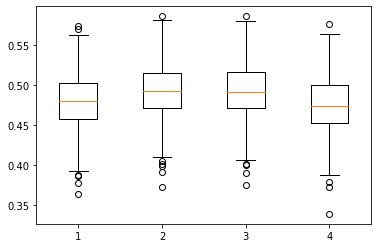

In [80]:
jiss = [[],[],[],[]]

for i in range(len(val_dataset480)):
    image, label = val_dataset480[i]
    label = label.chunk(chunks=15, dim=1)[7]
    for j in range(4):
        simage  = image[:, j*32+64:j*32+320, :, :].to(device=device).unsqueeze(0)
        pred, _ = JNet(simage)
        pred    = pred.to(device='cpu').squeeze(0)
        pred    = pred[:, 64:192, :, :]
        pred = pred[:, (3-j)*32:(4-j)*32, :, :].detach()
        jiss[3-j].append(jiffs(pred, label)) 
plt.boxplot((jiss))
plt.show()

In [82]:
for i in range(4):
    print(np.mean(jiss[i]), np.std(jiss[i]))

0.47990718 0.03663669
0.49307227 0.03574279
0.49284774 0.035666727
0.47585097 0.036073286


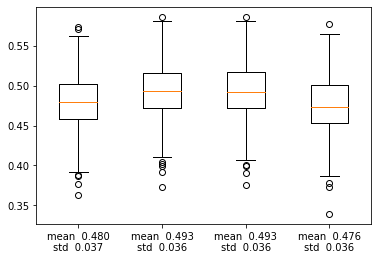

In [91]:
plt.boxplot((jiss))
plt.xticks([1,2,3,4],  [f"mean  {np.mean(jiss[i]):.3f}\nstd  {np.std(jiss[i]):.3f}"for i in range(4)])
plt.show()